# NVDA Fundamental Analysis (FY2021–FY2025) — Jupyter Notebook

This notebook is designed for **in-notebook writing + tables + charts** (perfect for later turning into a JupyterBook chapter).

## What you will get after running
1. **Raw statements downloaded** (Income Statement / Balance Sheet / Cash Flow) from Alpha Vantage  
   **Standardized FY2021–FY2025 tables**  
2. **Computed ratios** (profitability, leverage, growth, efficiency)
3. **Basic intrinsic valuation(Multiples)** 
4. **Basic intrinsic valuation(simple FCFF DCF)** 
5. **LLM-generated 1–2 page investment memo citing data sources.**

> **Important (API key safety):** Do **not** hardcode your Alpha Vantage key in this notebook if you plan to share/publish it. Use an environment variable or a local `secrets.env` file.


In [1]:
%pip install pandas numpy requests python-dotenv matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os, json, time
from pathlib import Path

import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt

from dotenv import load_dotenv

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)


## 1.1 Load API key (recommended)

### Option A (recommended): environment variable
In terminal:
```bash
export ALPHAVANTAGE_API_KEY="YOUR_KEY"
```

### Option B: local secrets file (NOT committed to git)
Create `secrets.env` in project root:
```text
ALPHAVANTAGE_API_KEY=YOUR_KEY
```

Then we load it below.


In [3]:
# Load secrets.env if present (safe for local work)
if Path("secrets.env").exists():
    load_dotenv("secrets.env")

API_KEY = os.getenv("ALPHAVANTAGE_API_KEY", "").strip()
if not API_KEY:
    raise RuntimeError("Missing ALPHAVANTAGE_API_KEY. Set env var or create secrets.env")

SYMBOL = "NVDA"


## 1.2 Data ingestion: Alpha Vantage company statements (annual)

We download three JSON files to `data_raw/alphavantage/`:
- Income statement
- Balance sheet
- Cash flow

> Alpha Vantage is rate-limited, so we sleep between calls.


In [4]:
AV_BASE = "https://www.alphavantage.co/query"

FUNCTIONS = {
    "income_statement": "INCOME_STATEMENT",
    "balance_sheet": "BALANCE_SHEET",
    "cash_flow": "CASH_FLOW",
}

RAW_DIR = Path("data_raw/alphavantage")
RAW_DIR.mkdir(parents=True, exist_ok=True)

def fetch_av_json(function: str, symbol: str, api_key: str) -> dict:
    params = {"function": function, "symbol": symbol, "apikey": api_key}
    r = requests.get(AV_BASE, params=params, timeout=60)
    r.raise_for_status()
    data = r.json()
    if "Error Message" in data:
        raise RuntimeError(f"Alpha Vantage error: {data['Error Message']}")
    if "Note" in data:
        raise RuntimeError(f"Alpha Vantage rate limit: {data['Note']}")
    return data

def save_json(data: dict, path: Path) -> None:
    path.write_text(json.dumps(data, indent=2), encoding="utf-8")

paths = {}
for name, fn in FUNCTIONS.items():
    out_path = RAW_DIR / f"{SYMBOL}_{name}.json"
    # If already downloaded, reuse (reproducible + avoids rate limit)
    if out_path.exists():
        paths[name] = out_path
        continue
    data = fetch_av_json(fn, SYMBOL, API_KEY)
    save_json(data, out_path)
    paths[name] = out_path
    time.sleep(12)  # conservative to avoid AV limits

paths


{'income_statement': PosixPath('data_raw/alphavantage/NVDA_income_statement.json'),
 'balance_sheet': PosixPath('data_raw/alphavantage/NVDA_balance_sheet.json'),
 'cash_flow': PosixPath('data_raw/alphavantage/NVDA_cash_flow.json')}

## 1.3 Standardize FY2021–FY2025 statements into clean tables

We extract `annualReports` and keep only fiscal years {2020, 2021, 2022, 2023, 2024}.

> Note: Alpha Vantage uses fiscal year ending dates; we label fiscal year by the year in `fiscalDateEnding`.


In [5]:
YEARS = {2021, 2022, 2023, 2024, 2025}

def load_reports(path: Path) -> list[dict]:
    data = json.loads(path.read_text(encoding="utf-8"))
    reps = data.get("annualReports", [])
    if not reps:
        raise RuntimeError(f"No annualReports found in {path}")
    return reps

def year_from_fiscal_date(s: str) -> int:
    return int(s[:4])

def to_int(x):
    try:
        return int(float(x))
    except Exception:
        return pd.NA

def standardize_income(path: Path) -> pd.DataFrame:
    reps = load_reports(path)
    rows = []
    for r in reps:
        y = year_from_fiscal_date(r["fiscalDateEnding"])
        if y not in YEARS:
            continue
        rows.append({
            "fiscal_year": y,
            "fiscal_date_ending": r["fiscalDateEnding"],
            "revenue": to_int(r.get("totalRevenue")),
            "cogs": to_int(r.get("costOfRevenue")),
            "gross_profit": to_int(r.get("grossProfit")),
            "operating_income": to_int(r.get("operatingIncome")),
            "net_income": to_int(r.get("netIncome")),
            "interest_expense": to_int(r.get("interestExpense")),
            "income_before_tax": to_int(r.get("incomeBeforeTax")),
            "income_tax_expense": to_int(r.get("incomeTaxExpense")),
        })
    return pd.DataFrame(rows).sort_values("fiscal_year").reset_index(drop=True)

def standardize_balance(path: Path) -> pd.DataFrame:
    reps = load_reports(path)
    rows = []
    for r in reps:
        y = year_from_fiscal_date(r["fiscalDateEnding"])
        if y not in YEARS:
            continue
        rows.append({
            "fiscal_year": y,
            "fiscal_date_ending": r["fiscalDateEnding"],
            "total_assets": to_int(r.get("totalAssets")),
            "total_liabilities": to_int(r.get("totalLiabilities")),
            "total_shareholder_equity": to_int(r.get("totalShareholderEquity")),
            "cash_and_cash_equivalents": to_int(r.get("cashAndCashEquivalentsAtCarryingValue")),
            "current_assets": to_int(r.get("totalCurrentAssets")),
            "current_liabilities": to_int(r.get("totalCurrentLiabilities")),
            "long_term_debt": to_int(r.get("longTermDebt")),
            "short_term_debt": to_int(r.get("shortTermDebt")),
            "short_term_investments": to_int(r.get("shortTermInvestments")),
             
        })
    return pd.DataFrame(rows).sort_values("fiscal_year").reset_index(drop=True)

def standardize_cashflow(path: Path) -> pd.DataFrame:
    reps = load_reports(path)
    rows = []
    for r in reps:
        y = year_from_fiscal_date(r["fiscalDateEnding"])
        if y not in YEARS:
            continue
        cfo = to_int(r.get("operatingCashflow"))
        capex = to_int(r.get("capitalExpenditures"))
        capex_outflow = abs(capex) if capex is not pd.NA else pd.NA  # AV often stores capex as negative
        da = to_int(r.get("depreciationDepletionAndAmortization")) 
        fcf = (cfo - capex_outflow) if (cfo is not pd.NA and capex_outflow is not pd.NA) else pd.NA
        rows.append({
            "fiscal_year": y,
            "fiscal_date_ending": r["fiscalDateEnding"],
            "operating_cash_flow": cfo,
            "capex": capex,
            "capex_outflow": capex_outflow,
            "free_cash_flow": fcf,
            "depreciation_and_amortization": da,
        })
    return pd.DataFrame(rows).sort_values("fiscal_year").reset_index(drop=True)

is_df = standardize_income(paths["income_statement"])
bs_df = standardize_balance(paths["balance_sheet"])
cf_df = standardize_cashflow(paths["cash_flow"])

is_df, bs_df, cf_df


(   fiscal_year fiscal_date_ending       revenue         cogs  gross_profit  operating_income   net_income  \
 0         2021         2021-01-31   16675000000   6279000000   10396000000        4532000000   4332000000   
 1         2022         2022-01-31   26914000000   9439000000   17475000000       10041000000   9752000000   
 2         2023         2023-01-31   26974000000  11618000000   15356000000        4224000000   4368000000   
 3         2024         2024-01-31   60922000000  16621000000   44301000000       32972000000  29760000000   
 4         2025         2025-01-31  130497000000  32639000000   97858000000       81453000000  72880000000   
 
    interest_expense  income_before_tax  income_tax_expense  
 0         184000000         4409000000            77000000  
 1         236000000         9941000000           189000000  
 2         262000000         4181000000          -187000000  
 3         257000000        33818000000          4058000000  
 4         247000000        

## 1.4 Quick view (scaled to $ billions)

For readability, we show major lines in **USD billions**.


In [6]:
def to_billions_inplace(df: pd.DataFrame, cols: list[str]) -> None:
    for c in cols:
        if c in df.columns:
            df[c] = df[c].astype("float64") / 1e9


# =========================
# 1) 先在“原始 long-format 数据”层统一单位（USD → USD billions）
# =========================
income_items = ["revenue","cogs","gross_profit","operating_income","net_income","interest_expense","income_before_tax",  
    "income_tax_expense"]
balance_items = [
    "total_assets","total_liabilities","total_shareholder_equity",
    "cash_and_cash_equivalents","current_assets", 
    "current_liabilities","long_term_debt","short_term_debt","short_term_investments" 
]
cashflow_items = ["operating_cash_flow","capex_outflow","depreciation_and_amortization","free_cash_flow"]

to_billions_inplace(is_df, income_items)
to_billions_inplace(bs_df, balance_items)
to_billions_inplace(cf_df, cashflow_items)


# =========================
# 2) 再转置（此时已经是 billion，不要再除 1e9）
# =========================
is_view = is_df.set_index("fiscal_year")[income_items].T
bs_view = bs_df.set_index("fiscal_year")[balance_items].T
cf_view = cf_df.set_index("fiscal_year")[cashflow_items].T

display(is_view)
display(bs_view)
display(cf_view)

fiscal_year,2021,2022,2023,2024,2025
revenue,16.675,26.914,26.974,60.922,130.497
cogs,6.279,9.439,11.618,16.621,32.639
gross_profit,10.396,17.475,15.356,44.301,97.858
operating_income,4.532,10.041,4.224,32.972,81.453
net_income,4.332,9.752,4.368,29.760,72.880
interest_expense,0.184,0.236,0.262,0.257,0.247
income_before_tax,4.409,9.941,4.181,33.818,84.026
income_tax_expense,0.077,0.189,-0.187,4.058,11.146


fiscal_year,2021,2022,2023,2024,2025
total_assets,28.791,44.187,41.182,65.728,111.601
total_liabilities,11.898,17.575,19.081,22.750,32.274
total_shareholder_equity,16.893,26.612,22.101,42.978,79.327
cash_and_cash_equivalents,0.847,1.990,3.389,7.280,8.589
current_assets,16.055,28.829,23.073,44.345,80.126
current_liabilities,3.925,4.335,6.563,10.631,18.047
long_term_debt,5.964,10.946,9.703,8.459,8.463
short_term_debt,0.999,0.144,1.250,1.478,0.288
short_term_investments,10.714,19.218,9.907,18.704,34.621


fiscal_year,2021,2022,2023,2024,2025
operating_cash_flow,5.822,9.108,5.641,28.090,64.089
capex_outflow,1.128,0.976,1.833,1.069,3.236
depreciation_and_amortization,1.098,1.174,1.544,1.508,1.864
free_cash_flow,4.694,8.132,3.808,27.021,60.853


## 2 Compute key ratios (profitability, leverage, growth, efficiency)

We merge the three statements by fiscal year, then compute:

- **Profitability:** gross/operating/net margin, ROA, ROE  
- **Leverage & liquidity:** debt-to-equity, current ratio, interest coverage  
- **Growth:** YoY for revenue / net income / FCF  
- **Efficiency & quality:** asset turnover, FCF margin, CFO-to-net-income


### Profitability: gross/operating/net margin, ROA, ROE

In [7]:
df = (
    is_df.merge(bs_df, on=["fiscal_year","fiscal_date_ending"], how="inner")
         .merge(cf_df, on=["fiscal_year","fiscal_date_ending"], how="inner")
         .sort_values("fiscal_year")
         .reset_index(drop=True)
)

# Averages for ROA/ROE
df["avg_assets"] = (df["total_assets"] + df["total_assets"].shift(1)) / 2
df["avg_equity"] = (df["total_shareholder_equity"] + df["total_shareholder_equity"].shift(1)) / 2


# 手动填 2021 的 avg
assets_2020=17.32
equity_2020=12.2 
df.loc[df["fiscal_year"] == 2021, "avg_assets"] = (
    df.loc[df["fiscal_year"] == 2021, "total_assets"].values[0] + assets_2020
) / 2

df.loc[df["fiscal_year"] == 2021, "avg_equity"] = (
    df.loc[df["fiscal_year"] == 2021, "total_shareholder_equity"].values[0] + equity_2020
) / 2

# Profitability
df["gross_margin"] = (df["revenue"] - df["cogs"]) / df["revenue"]
df["operating_margin"] = df["operating_income"] / df["revenue"]
df["net_margin"] = df["net_income"] / df["revenue"]
df["roa"] = df["net_income"] / df["avg_assets"]
df["roe"] = df["net_income"] / df["avg_equity"]

 


In [8]:
metric_cols = [
    "gross_margin",
    "operating_margin",
    "net_margin",
    "roa",
    "roe"
]


metrics_table = (
    df.set_index("fiscal_year")[metric_cols]
      .T
      .rename(index={
          "gross_margin": "Gross margin",
          "operating_margin": "Operating margin",
          "net_margin": "Net margin",
          "roa": "ROA",
          "roe": "ROE"
      })
)


metrics_table = metrics_table.round(4)

metrics_table


fiscal_year,2021,2022,2023,2024,2025
Gross margin,0.6234,0.6493,0.5693,0.7272,0.7499
Operating margin,0.2718,0.3731,0.1566,0.5412,0.6242
Net margin,0.2598,0.3623,0.1619,0.4885,0.5585
ROA,0.1879,0.2673,0.1023,0.5567,0.8220
ROE,0.2978,0.4483,0.1793,0.9146,1.1918


In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

def plot_metric_ax(ax, df, col, title, is_percent=False):
    ax.plot(df.index, df[col])
    ax.set_title(title)

    if is_percent:
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))


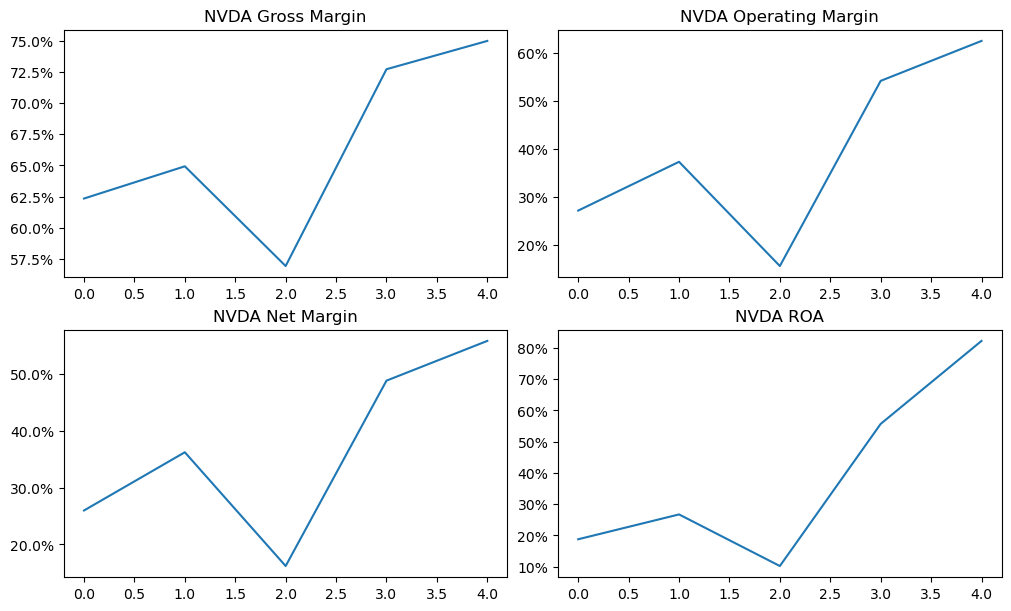

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6), constrained_layout=True)
axes = axes.flatten()

metrics_4 = [
    ("gross_margin", "Gross Margin"),
    ("operating_margin", "Operating Margin"),
    ("net_margin", "Net Margin"),
    ("roa", "ROA"),
]

for ax, (col, title) in zip(axes, metrics_4):
    plot_metric_ax(
        ax=ax,
        df=df,
        col=col,
        title=f"NVDA {title}",
        is_percent=True
    )

plt.show()



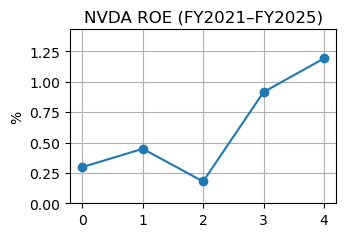

In [308]:
fig2, axes2 = plt.subplots(
    2, 2,
    figsize=(6, 4),
    constrained_layout=True
)

plot_metric_ax(
    ax=axes2[0, 0],
    df=df,
    col="roe",
    title="NVDA ROE (FY2021–FY2025)",
    is_percent=True
)

fig2.delaxes(axes2[0, 1])
fig2.delaxes(axes2[1, 0])
fig2.delaxes(axes2[1, 1])

plt.show()


**Gross Margin**  
NVIDIA’s gross margin remained in the low-to-mid 60% range in FY2021–FY2022, declined in FY2023 due to cyclical weakness, and rebounded sharply above 70% in FY2024–FY2025. This pattern reflects a transition from cyclical pressure to strong pricing power driven by AI-related demand and a favorable product mix.    
**Operating Margin**  
Operating margin peaked in FY2022, contracted sharply in FY2023 as fixed costs weighed on earnings during the downturn, and surged in FY2024–FY2025. The strong rebound highlights exceptional operating leverage, as revenue growth outpaced cost expansion in the AI upcycle.    
**Net Margin**  
Net margin closely follows operating margin, indicating that profitability is primarily driven by core operations. The sharp improvement in FY2024–FY2025 suggests a structural enhancement in earnings quality rather than temporary financial effects.   
**ROA**  
ROA declined in FY2023 as asset growth outpaced earnings during the slowdown, then increased sharply in FY2024–FY2025, signaling a significant improvement in asset efficiency and the firm’s ability to generate profits from its asset base amid strong demand.    
**ROE**  
ROE remained high in FY2021–FY2022, fell in FY2023, and surged to exceptionally high levels in FY2024–FY2025. This reflects extraordinary shareholder value creation driven by superior profitability and strong operating leverage, though the magnitude in FY2025 appears optimistic relative to sustainable industry norms.  

### Leverage & liquidity: debt-to-equity, current ratio, interest coverage

In [309]:
 # Leverage / liquidity
df["debt_total"] = df[["long_term_debt","short_term_debt"]].sum(axis=1, min_count=1)
df["debt_to_equity"] = df["debt_total"] / df["total_shareholder_equity"]
df["current_ratio"] = df["current_assets"] / df["current_liabilities"]
df["interest_coverage"] = df["operating_income"] / df["interest_expense"]


In [310]:
 leverage_cols = [
    "debt_to_equity",
    "current_ratio",
    "interest_coverage"
]

leverage_table = (
    df.set_index("fiscal_year")[leverage_cols]
      .T
      .rename(index={
          "debt_to_equity": "Debt-to-Equity",
          "current_ratio": "Current Ratio",
          "interest_coverage": "Interest Coverage"
      })
)

leverage_table = leverage_table.round(4)

leverage_table


fiscal_year,2021,2022,2023,2024,2025
Debt-to-Equity,0.4122,0.4167,0.4956,0.2312,0.1103
Current Ratio,4.0904,6.6503,3.5156,4.1713,4.4399
Interest Coverage,24.6304,42.5466,16.1221,128.2957,329.7692


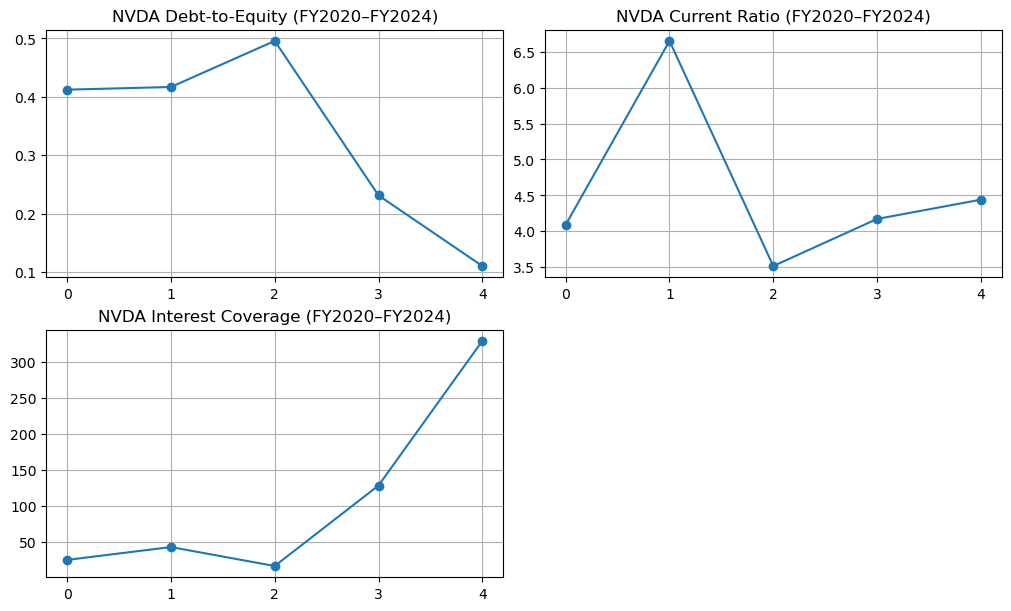

In [311]:
fig, axes = plt.subplots(
    2, 2,
    figsize=(10, 6),
    constrained_layout=True
)

# Debt-to-Equity
plot_metric_ax(
    ax=axes[0, 0],
    df=df,
    col="debt_to_equity",
    title="NVDA Debt-to-Equity (FY2020–FY2024)",
    is_percent=False
)

# Current Ratio
plot_metric_ax(
    ax=axes[0, 1],
    df=df,
    col="current_ratio",
    title="NVDA Current Ratio (FY2020–FY2024)",
    is_percent=False
)

# Interest Coverage
plot_metric_ax(
    ax=axes[1, 0],
    df=df,
    col="interest_coverage",
    title="NVDA Interest Coverage (FY2020–FY2024)",
    is_percent=False
)

# 删掉右下角空图
fig.delaxes(axes[1, 1])

plt.show()


**Debt-to-Equity Ratio**  
NVIDIA’s debt-to-equity ratio increased steadily from FY2021 to FY2023, indicating a gradual rise in financial leverage during the industry downturn. The sharp decline in FY2024–FY2025 reflects rapid equity expansion driven by exceptional profitability, suggesting a material reduction in balance sheet risk.  
**Current Ratio**  
The firm maintained a consistently high current ratio throughout the period, highlighting strong short-term liquidity and conservative working capital management. The temporary dip in FY2023 corresponds to weaker operating conditions, while the recovery in FY2024–FY2025 indicates improved cash generation following the AI-driven earnings surge.    
**Interest Coverage Ratio**    
Interest coverage remained comfortably high in FY2021–FY2022, deteriorated in FY2023 due to lower operating income, and then rebounded dramatically in FY2024–FY2025. This sharp increase demonstrates NVIDIA’s exceptional debt-servicing capacity and implies that solvency risk has become negligible under current earnings conditions.  

### Growth: YoY for revenue / net income / FCF

In [312]:
# Growth (df 已经是 USD billions)
df["revenue_yoy"] = df["revenue"].pct_change()
df["net_income_yoy"] = df["net_income"].pct_change()
df["fcf_yoy"] = df["free_cash_flow"].pct_change()

# 2020 values in USD billions (与你 df 单位一致)
revenue_2020 = 10.92
net_income_2020 = 2.8
fcf_2020 = 4.27

df.loc[df["fiscal_year"] == 2021, "revenue_yoy"] = (
    df.loc[df["fiscal_year"] == 2021, "revenue"].values[0] / revenue_2020 - 1
)
df.loc[df["fiscal_year"] == 2021, "net_income_yoy"] = (
    df.loc[df["fiscal_year"] == 2021, "net_income"].values[0] / net_income_2020 - 1
)
df.loc[df["fiscal_year"] == 2021, "fcf_yoy"] = (
    df.loc[df["fiscal_year"] == 2021, "free_cash_flow"].values[0] / fcf_2020 - 1
)



In [313]:
growth_cols = [
    "revenue_yoy",
    "net_income_yoy",
    "fcf_yoy"
]

growth_table = (
    df.set_index("fiscal_year")[growth_cols]
      .T
      .rename(index={
          "revenue_yoy": "Revenue YoY Growth",
          "net_income_yoy": "Net Income YoY Growth",
          "fcf_yoy": "FCF YoY Growth"
      })
)

growth_table = growth_table.round(4)

growth_table


fiscal_year,2021,2022,2023,2024,2025
Revenue YoY Growth,0.5270,0.6140,0.0022,1.2585,1.1420
Net Income YoY Growth,0.5471,1.2512,-0.5521,5.8132,1.4489
FCF YoY Growth,0.0993,0.7324,-0.5317,6.0959,1.2521


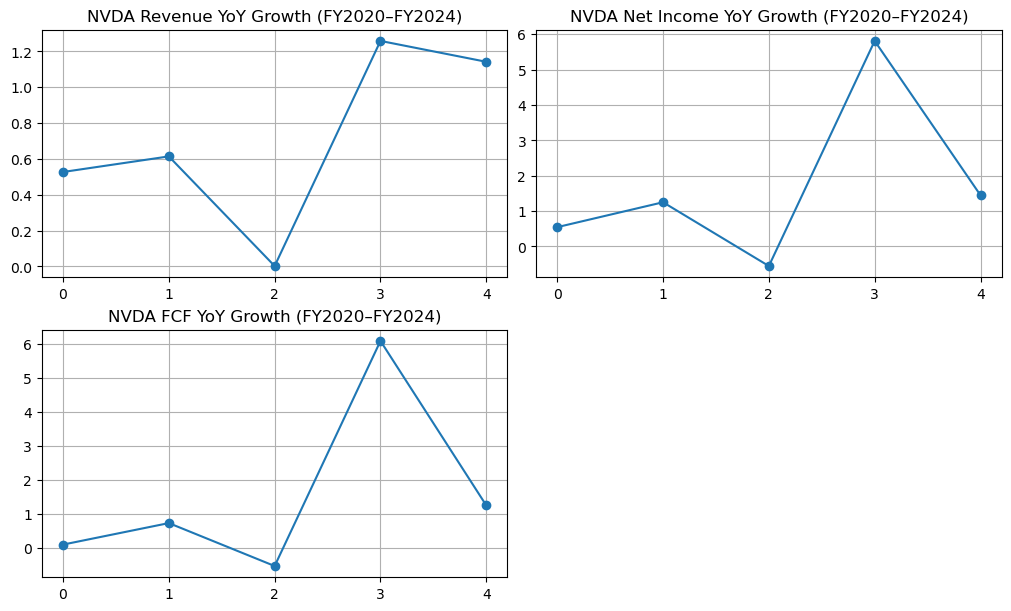

In [314]:
  fig, axes = plt.subplots(
    2, 2,
    figsize=(10, 6),
    constrained_layout=True
)

# Revenue growth
plot_metric_ax(
    ax=axes[0, 0],
    df=df,
    col="revenue_yoy",
    title="NVDA Revenue YoY Growth (FY2020–FY2024)"
)

# Net income growth
plot_metric_ax(
    ax=axes[0, 1],
    df=df,
    col="net_income_yoy",
    title="NVDA Net Income YoY Growth (FY2020–FY2024)"
)

# FCF growth
plot_metric_ax(
    ax=axes[1, 0],
    df=df,
    col="fcf_yoy",
    title="NVDA FCF YoY Growth (FY2020–FY2024)"
)

# 删掉右下角空图
fig.delaxes(axes[1, 1])

plt.show()


**Revenue Growth**  
NVIDIA experienced strong revenue growth in FY2021–FY2022, reflecting robust demand across gaming and data center segments. Growth stalled in FY2023 amid a cyclical industry downturn. In FY2024, revenue rebounded sharply, driven by an unprecedented surge in AI-related demand, with FY2025 sustaining elevated growth levels.  
**Net Income Growth**  
Net income growth outpaced revenue growth in FY2022, highlighting strong operating leverage. The sharp contraction in FY2023 reflects margin compression during the downturn. The extraordinary rebound in FY2024 demonstrates a structural improvement in profitability, while FY2025 indicates normalization at a still elevated growth rate.   
**Free Cash Flow Growth**  
Free cash flow growth was volatile over the period, with strong expansion in FY2022 followed by a contraction in FY2023 due to investment cycles and working capital effects. The explosive rebound in FY2024 shows NVIDIA’s strong cash flow conversion from earnings, and FY2025 suggests continued normalization after the initial AI-driven surge.  

### Efficiency & quality: asset turnover, FCF margin, CFO-to-net-income

In [315]:
# Efficiency / cash quality
df["asset_turnover"] = df["revenue"] / df["avg_assets"]
df["fcf_margin"] = df["free_cash_flow"] / df["revenue"]
df["cfo_to_net_income"] = df["operating_cash_flow"] / df["net_income"]

In [316]:
efficiency_cols = [
    "asset_turnover",
    "fcf_margin",
    "cfo_to_net_income"
]

efficiency_table = (
    df.set_index("fiscal_year")[efficiency_cols]
      .T
      .rename(index={
          "asset_turnover": "Asset Turnover",
          "fcf_margin": "FCF Margin",
          "cfo_to_net_income": "CFO / Net Income"
      })
)

efficiency_table = efficiency_table.round(4)
efficiency_table


fiscal_year,2021,2022,2023,2024,2025
Asset Turnover,0.7233,0.7376,0.6319,1.1397,1.4718
FCF Margin,0.2815,0.3021,0.1412,0.4435,0.4663
CFO / Net Income,1.3440,0.9340,1.2914,0.9439,0.8794


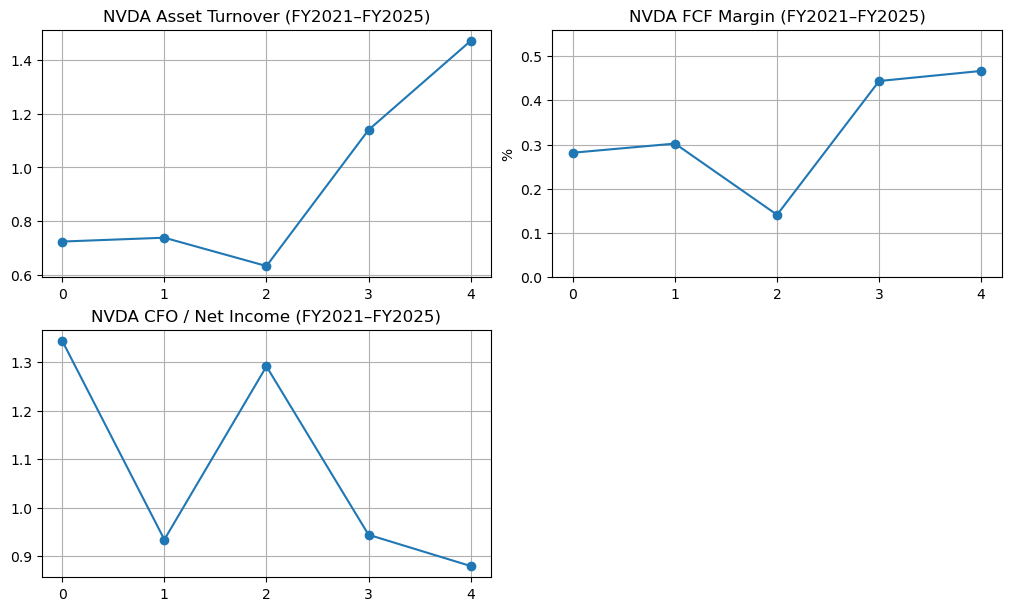

In [317]:

 fig, axes = plt.subplots(
    2, 2,
    figsize=(10, 6),
    constrained_layout=True
)

# Asset Turnover（不是百分比）
plot_metric_ax(
    ax=axes[0, 0],
    df=df,
    col="asset_turnover",
    title="NVDA Asset Turnover (FY2021–FY2025)",
    is_percent=False
)

# FCF Margin（百分比）
plot_metric_ax(
    ax=axes[0, 1],
    df=df,
    col="fcf_margin",
    title="NVDA FCF Margin (FY2021–FY2025)",
    is_percent=True
)

# CFO / Net Income（不是百分比）
plot_metric_ax(
    ax=axes[1, 0],
    df=df,
    col="cfo_to_net_income",
    title="NVDA CFO / Net Income (FY2021–FY2025)",
    is_percent=False
)

# 删除右下角空图
fig.delaxes(axes[1, 1])

plt.show()


**Asset Turnover**  
NVIDIA’s asset turnover remained stable in FY2021–FY2022 and declined in FY2023 due to weaker demand and underutilized assets during the industry downturn. The sharp increase in FY2024–FY2025 suggests a significant improvement in asset utilization driven by AI-related revenue growth. However, the magnitude implies an optimistic upper-bound scenario relative to typical semiconductor asset intensity.  
**Free Cash Flow Margin**  
Free cash flow margin showed pronounced cyclicality over the period. After compressing sharply in FY2023, margins rebounded strongly in FY2024–FY2025, reflecting improved profitability and favorable working capital dynamics. This highlights NVIDIA’s strong ability to convert earnings growth into cash during the AI-driven upcycle.  
**CFO / Net Income**  
The CFO-to-net-income ratio fluctuated around unity, indicating generally high earnings quality. Periods where the ratio exceeded one suggest strong cash realization relative to reported earnings, while ratios below one reflect temporary working capital effects rather than structural weaknesses in cash flow generation.

## 3 Basic intrinsic valuation(Muptiples)  

### Multiples（Relative valuation）

**Peer selection rationale for relative valuation**

ADI, QCOM, and TXN are selected as peers for NVIDIA in the relative valuation analysis because they operate within the same semiconductor industry and share asset-light, design-focused business models, making valuation multiples more comparable. All three firms exhibit high margins, strong pricing power, and stable cash flow generation, which reduces distortions arising from capital intensity and accounting differences.

Moreover, these companies represent a mature, high-quality benchmark against which NVIDIA’s significantly higher valuation multiples can be interpreted primarily as a reflection of its superior growth expectations and strategic positioning in AI, rather than structural differences in business models.

In [60]:
import json
import time
from pathlib import Path

import numpy as np
import pandas as pd
import requests
import yfinance as yf

# =========================
# Config
# =========================
TICKERS = ["NVDA", "ADI", "QCOM", "TXN"]
ASOF = pd.Timestamp("2025-01-31")
USD_BN = 1e9

API_KEY = "IJ7ZIVGOTVAU1POT"  # <-- 改这里
AV_BASE = "https://www.alphavantage.co/query"

RAW_DIR = Path("data_raw/alphavantage")
RAW_DIR.mkdir(parents=True, exist_ok=True)

FUNCTIONS = {
    "income_statement": "INCOME_STATEMENT",
    "cash_flow": "CASH_FLOW",
    "balance_sheet": "BALANCE_SHEET",
}


def close_on_or_before(symbol: str, asof: pd.Timestamp):
    t = yf.Ticker(symbol)
    start = (asof - pd.Timedelta(days=10)).strftime("%Y-%m-%d")
    end = (asof + pd.Timedelta(days=1)).strftime("%Y-%m-%d")
    hist = t.history(start=start, end=end, auto_adjust=False)
    if hist.empty:
        return np.nan, None
    hist = hist.copy()
    hist.index = hist.index.tz_localize(None)
    hist = hist.loc[hist.index <= asof]
    if hist.empty:
        return np.nan, None
    px = float(hist["Close"].iloc[-1])
    px_date = pd.Timestamp(hist.index[-1]).date()
    return px, px_date

# =========================
# Helpers: Alpha Vantage fetch + cache
# =========================
def fetch_av_json(function: str, symbol: str, api_key: str) -> dict:
    params = {"function": function, "symbol": symbol, "apikey": api_key}
    r = requests.get(AV_BASE, params=params, timeout=60)
    r.raise_for_status()
    data = r.json()
    if "Error Message" in data:
        raise RuntimeError(f"Alpha Vantage error: {data['Error Message']}")
    if "Note" in data:
        raise RuntimeError(f"Alpha Vantage rate limit: {data['Note']}")
    return data

def load_or_fetch_av(symbol: str, name: str, function: str, api_key: str) -> dict:
    path = RAW_DIR / f"{symbol}_{name}.json"
    if path.exists():
        return json.loads(path.read_text(encoding="utf-8"))
    data = fetch_av_json(function, symbol, api_key)
    path.write_text(json.dumps(data, indent=2), encoding="utf-8")
    time.sleep(12)  # AV free-tier limit friendly
    return data

def to_float(x):
    try:
        if x is None:
            return np.nan
        return float(x)
    except Exception:
        return np.nan

def parse_date(s: str) -> pd.Timestamp:
    return pd.Timestamp(s)

def pick_last_quarters(reports: list[dict], asof: pd.Timestamp, n: int = 4) -> list[dict]:
    """
    Pick last n quarterly reports with fiscalDateEnding <= asof.
    """
    rows = []
    for r in reports:
        dt = parse_date(r["fiscalDateEnding"])
        if dt <= asof:
            rows.append((dt, r))
    rows.sort(key=lambda x: x[0])  # ascending
    if len(rows) < n:
        return []
    return [r for _, r in rows[-n:]]

def pick_latest_report(reports: list[dict], asof: pd.Timestamp) -> dict | None:
    """
    Pick latest single quarterly report with fiscalDateEnding <= asof.
    """
    rows = []
    for r in reports:
        dt = parse_date(r["fiscalDateEnding"])
        if dt <= asof:
            rows.append((dt, r))
    if not rows:
        return None
    rows.sort(key=lambda x: x[0])
    return rows[-1][1]

# =========================
# Extract TTM + Balance snapshot from AV
# =========================
def av_ttm_income_cash_balance(symbol: str, asof: pd.Timestamp, api_key: str):
    inc = load_or_fetch_av(symbol, "income_statement", FUNCTIONS["income_statement"], api_key)
    cf  = load_or_fetch_av(symbol, "cash_flow", FUNCTIONS["cash_flow"], api_key)
    bs  = load_or_fetch_av(symbol, "balance_sheet", FUNCTIONS["balance_sheet"], api_key)

    q_inc = inc.get("quarterlyReports", []) or []
    q_cf  = cf.get("quarterlyReports", []) or []
    q_bs  = bs.get("quarterlyReports", []) or []

    last4_inc = pick_last_quarters(q_inc, asof, n=4)
    last4_cf  = pick_last_quarters(q_cf, asof, n=4)

    # If not enough quarters, return NaNs (but for your tickers it should usually be OK)
    if len(last4_inc) < 4:
        revenue_ttm = np.nan
        net_income_ttm = np.nan
        ebit_ttm = np.nan
        last_q_used = None
    else:
        revenue_ttm = sum(to_float(r.get("totalRevenue")) for r in last4_inc)
        net_income_ttm = sum(to_float(r.get("netIncome")) for r in last4_inc)
        # Some tickers have "ebit", some don't; fallback to operatingIncome if missing
        ebit_ttm = 0.0
        miss = 0
        for r in last4_inc:
            v = to_float(r.get("ebit"))
            if pd.isna(v):
                v = to_float(r.get("operatingIncome"))
            if pd.isna(v):
                miss += 1
            else:
                ebit_ttm += v
        if miss > 0:
            ebit_ttm = np.nan
        last_q_used = last4_inc[-1]["fiscalDateEnding"]

    # D&A TTM from cash flow (field name varies; AV quarterly cashflow usually includes depreciationDepletionAndAmortization)
    if len(last4_cf) < 4:
        da_ttm = np.nan
        last_q_cf_used = None
    else:
        # Try a few possible keys
        da_keys = ["depreciationDepletionAndAmortization", "depreciationAndAmortization", "depreciation"]
        da_vals = []
        for r in last4_cf:
            v = np.nan
            for k in da_keys:
                v = to_float(r.get(k))
                if pd.notna(v):
                    break
            da_vals.append(v)
        da_ttm = np.nan if any(pd.isna(v) for v in da_vals) else float(np.sum(da_vals))
        last_q_cf_used = last4_cf[-1]["fiscalDateEnding"]

    ebitda_ttm = (ebit_ttm + da_ttm) if (pd.notna(ebit_ttm) and pd.notna(da_ttm)) else np.nan

    # Balance sheet snapshot (latest quarter <= asof)
    bs_last = pick_latest_report(q_bs, asof)
    if bs_last is None:
        cash = np.nan
        total_debt = np.nan
        bs_used = None
    else:
        bs_used = bs_last["fiscalDateEnding"]
        cash = to_float(bs_last.get("cashAndCashEquivalentsAtCarryingValue"))
        # Debt fields in AV balance sheet can differ:
        debt_lt = to_float(bs_last.get("longTermDebt"))
        debt_st = to_float(bs_last.get("shortLongTermDebtTotal"))  # often total ST + current portion
        # If any missing, still try to sum robustly
        debt_lt = 0.0 if pd.isna(debt_lt) else debt_lt
        debt_st = 0.0 if pd.isna(debt_st) else debt_st
        total_debt = debt_lt + debt_st

    return {
        "Revenue_TTM": revenue_ttm,
        "NetIncome_TTM": net_income_ttm,
        "EBITDA_TTM": ebitda_ttm,
        "Cash": cash,
        "TotalDebt": total_debt,
        "TTM_Income_LastQuarterUsed": last_q_used,
        "TTM_CF_LastQuarterUsed": last_q_cf_used,
        "Balance_LastQuarterUsed": bs_used,
    }

# =========================
# Shares outstanding (best-effort, via yfinance info)
# =========================
def shares_outstanding_yf(symbol: str) -> float:
    t = yf.Ticker(symbol)
    info = {}
    try:
        info = t.get_info()
    except Exception:
        info = getattr(t, "info", {}) or {}
    x = info.get("sharesOutstanding", None)
    try:
        return float(x)
    except Exception:
        return np.nan

# =========================
# Build final table (items x tickers)
# =========================
def extract_peer_row(symbol: str, asof: pd.Timestamp, api_key: str) -> pd.Series:
    px, px_date = close_on_or_before(symbol, asof)
    sh = shares_outstanding_yf(symbol)

    av = av_ttm_income_cash_balance(symbol, asof, api_key)

    # MarketCap at as-of (approx) = price(as-of)*shares
    mkt = (px * sh) if (pd.notna(px) and pd.notna(sh)) else np.nan

    s = pd.Series(
        {
            "StockPrice (USD/share)": px,
            "NetIncome_TTM (USD bn)": av["NetIncome_TTM"]/USD_BN if pd.notna(av["NetIncome_TTM"]) else np.nan,
            "SharesOutstanding (bn shares)": sh/USD_BN if pd.notna(sh) else np.nan,
            "MarketCap (USD bn)": mkt/USD_BN if pd.notna(mkt) else np.nan,
            "TotalDebt (USD bn)": av["TotalDebt"]/USD_BN if pd.notna(av["TotalDebt"]) else np.nan,
            "Cash (USD bn)": av["Cash"]/USD_BN if pd.notna(av["Cash"]) else np.nan,
            "EBITDA_TTM (USD bn)": av["EBITDA_TTM"]/USD_BN if pd.notna(av["EBITDA_TTM"]) else np.nan,
            "Revenue_TTM (USD bn)": av["Revenue_TTM"]/USD_BN if pd.notna(av["Revenue_TTM"]) else np.nan,
            # audit (optional)
            "PriceDateUsed": str(px_date) if px_date is not None else np.nan,
            "TTM_Income_LastQuarterUsed": av["TTM_Income_LastQuarterUsed"],
            "TTM_CF_LastQuarterUsed": av["TTM_CF_LastQuarterUsed"],
            "Balance_LastQuarterUsed": av["Balance_LastQuarterUsed"],
        },
        name=symbol,
    )
    return s

table = pd.concat([extract_peer_row(sym, ASOF, API_KEY) for sym in TICKERS], axis=1)

row_order = [
    "StockPrice (USD/share)",
    "NetIncome_TTM (USD bn)",
    "SharesOutstanding (bn shares)",
    "MarketCap (USD bn)",
    "TotalDebt (USD bn)",
    "Cash (USD bn)",
    "EBITDA_TTM (USD bn)",
    "Revenue_TTM (USD bn)",
    "PriceDateUsed",
    "TTM_Income_LastQuarterUsed",
    "TTM_CF_LastQuarterUsed",
    "Balance_LastQuarterUsed",
]
table = table.loc[row_order]

# Hide audit rows for display
rows_to_hide = [
    "PriceDateUsed",
    "TTM_Income_LastQuarterUsed",
    "TTM_CF_LastQuarterUsed",
    "Balance_LastQuarterUsed",
]
table_display = table.drop(index=rows_to_hide)

display(table_display)


,NVDA,ADI,QCOM,TXN
StockPrice (USD/share),120.07,211.889999,172.929993,184.610001
NetIncome_TTM (USD bn),72.88,1.563862,10.555,4.799
SharesOutstanding (bn shares),24.305,0.489654,1.071,0.908623
MarketCap (USD bn),2918.301343,103.752806,185.208022,167.740896
TotalDebt (USD bn),18.733,14.18537,27.789,26.442
Cash (USD bn),8.589,2.349994,8.713,3.2
EBITDA_TTM (USD bn),86.137,4.114516,12.915,7.541
Revenue_TTM (USD bn),130.497,9.337627,40.695,15.641


In [319]:
ev = (
    table_display.loc["MarketCap (USD bn)"]
    + table_display.loc["TotalDebt (USD bn)"]
    - table_display.loc["Cash (USD bn)"]
)

multiples_ttm = pd.DataFrame({
    "P/E (TTM)": table_display.loc["MarketCap (USD bn)"] / table_display.loc["NetIncome_TTM (USD bn)"],
    "EV/EBITDA (TTM)": ev / table_display.loc["EBITDA_TTM (USD bn)"],
    "EV/Sales (TTM)": ev / table_display.loc["Revenue_TTM (USD bn)"],
}).round(2)

display(multiples_ttm)



,P/E (TTM),EV/EBITDA (TTM),EV/Sales (TTM)
NVDA,40.042554,33.997531,22.44071
ADI,66.343965,28.092777,12.378753
QCOM,17.546947,15.817578,5.01988
TXN,34.953302,25.325938,12.210402


In [320]:
multiples_ttm.loc["Semiconductor Avg"] = [37.29, 42.70, 15.70]
multiples_ttm.loc["Market Avg (S&P500)"] = [27.66, 23.95, 3.97]

display(multiples_ttm)

,P/E (TTM),EV/EBITDA (TTM),EV/Sales (TTM)
NVDA,40.042554,33.997531,22.44071
ADI,66.343965,28.092777,12.378753
QCOM,17.546947,15.817578,5.01988
TXN,34.953302,25.325938,12.210402
Semiconductor Avg,37.29,42.7,15.7
Market Avg (S&P500),27.66,23.95,3.97


Market and industry valuation benchmarks are obtained from Professor Aswath Damodaran’s valuation database (NYU Stern School of Business):
https://pages.stern.nyu.edu/~adamodar/New_Home_Page/datafile/vebitda.html

According to the latest data, the U.S. total market averages are P/E = 27.66×, EV/Sales = 3.97×, and EV/EBITDA = 23.95×. In comparison, the semiconductor industry averages are substantially higher, with P/E = 37.29×, EV/Sales = 15.70×, and EV/EBITDA = 42.70×. These benchmarks are used as reference multiples for relative valuation analysis.

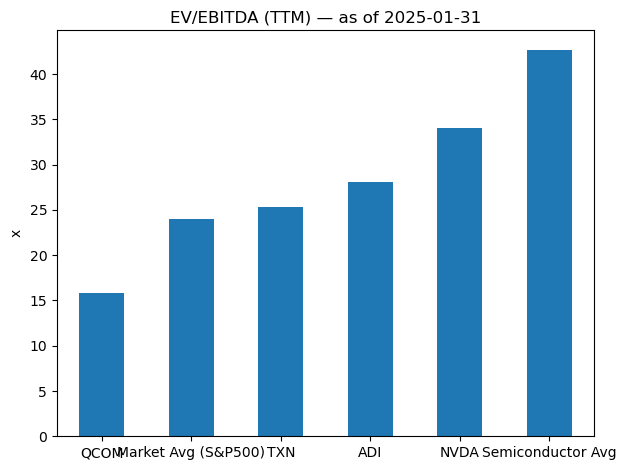

In [321]:
import matplotlib.pyplot as plt
 
ax = multiples_ttm["EV/EBITDA (TTM)"].sort_values().plot(kind="bar", title="EV/EBITDA (TTM) — as of 2025-01-31", rot=0)
ax.set_ylabel("x")
plt.tight_layout()
plt.show()



NVIDIA trades at a clear premium on EV/EBITDA, standing materially above both its closest peers (ADI, TXN, QCOM) and the broader market benchmark. While the semiconductor industry average appears even higher, NVIDIA remains firmly positioned in the upper valuation range, reflecting strong market confidence in its AI-driven growth, superior margins, and operating leverage. Overall, the elevated multiple suggests that NVIDIA is priced as a structurally differentiated growth platform rather than a traditional cyclical semiconductor manufacturer.

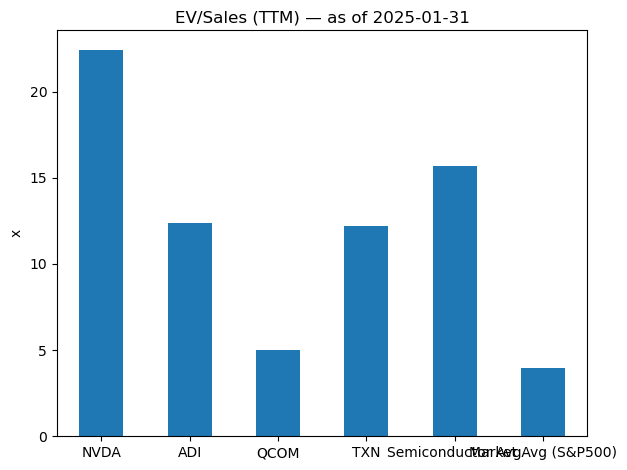

In [322]:
import matplotlib.pyplot as plt
 
order = ["NVDA", "ADI", "QCOM", "TXN","Semiconductor Avg","Market Avg (S&P500)"]

ax = multiples_ttm.loc[order, "EV/Sales (TTM)"].plot(
    kind="bar",
    title="EV/Sales (TTM) — as of 2025-01-31",
    rot=0
)
ax.set_ylabel("x")
plt.tight_layout()
plt.show()



NVIDIA trades at by far the highest EV/Sales multiple among peers and stands well above both the semiconductor industry average and the broader market benchmark. This indicates that the market prices NVIDIA not merely as a semiconductor manufacturer, but as a structurally superior growth platform with exceptional revenue scalability and pricing power driven by AI demand.

/var/folders/67/z6yb8mb57854wbnx5q8y_kkc0000gn/T/ipykernel_85064/306914270.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pe = pe.replace([np.inf, -np.inf], np.nan)


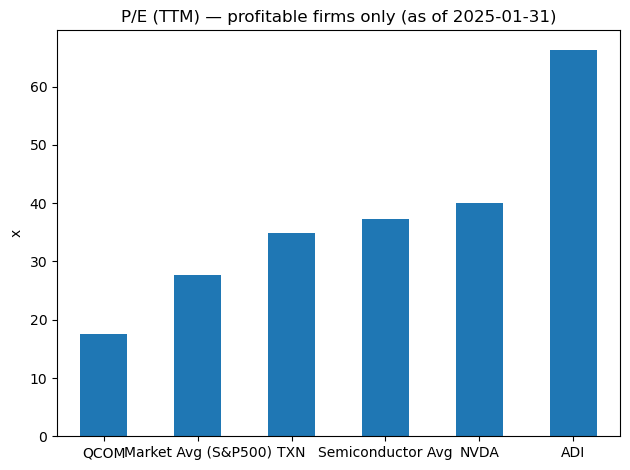

In [323]:
import matplotlib.pyplot as plt
import numpy as np

pe = multiples_ttm["P/E (TTM)"].copy()
# keep only meaningful P/E (positive and finite)
pe = pe.replace([np.inf, -np.inf], np.nan)
pe = pe[pe > 0].dropna()

ax = pe.sort_values().plot(kind="bar", title="P/E (TTM) — profitable firms only (as of 2025-01-31)", rot=0)
ax.set_ylabel("x")
plt.tight_layout()
plt.show()


NVIDIA trades at a P/E multiple above both the semiconductor industry average and the broader market benchmark, indicating that investors are willing to pay a premium for its superior earnings growth and AI-driven profitability. Although ADI commands an even higher P/E due to its more mature and stable earnings base, NVIDIA remains clearly positioned in the upper valuation tier of the sector.

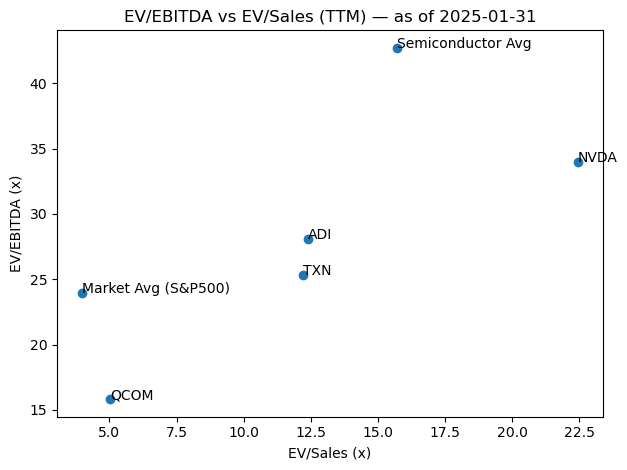

In [324]:
import matplotlib.pyplot as plt

x = multiples_ttm["EV/Sales (TTM)"]
y = multiples_ttm["EV/EBITDA (TTM)"]

plt.figure()
plt.scatter(x, y)

for name in multiples_ttm.index:
    plt.annotate(name, (x.loc[name], y.loc[name]))

plt.title("EV/EBITDA vs EV/Sales (TTM) — as of 2025-01-31")
plt.xlabel("EV/Sales (x)")
plt.ylabel("EV/EBITDA (x)")
plt.tight_layout()
plt.show()


NVIDIA is positioned in the upper-right corner of the valuation space, exhibiting both the highest EV/Sales and one of the highest EV/EBITDA multiples among peers. This dual-premium positioning indicates that the market prices NVIDIA not only for superior growth but also for exceptional profitability, distinguishing it structurally from traditional semiconductor peers.

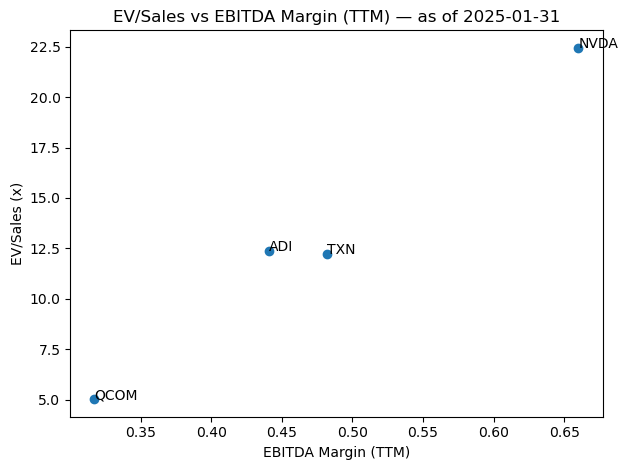

In [34]:
import matplotlib.pyplot as plt

# EBITDA margin (只在 table_display 有的公司里)
ebitda_margin = (
    table_display.loc["EBITDA_TTM (USD bn)"] / table_display.loc["Revenue_TTM (USD bn)"]
)

# 只取“同时存在”的行（避免 Semiconductor Avg / Market Avg 造成 KeyError）
common = ebitda_margin.index.intersection(multiples_ttm.index)

x = ebitda_margin.loc[common]
y = multiples_ttm.loc[common, "EV/Sales (TTM)"]

plt.figure()
plt.scatter(x, y)

for name in common:
    plt.annotate(name, (x.loc[name], y.loc[name]))

plt.title("EV/Sales vs EBITDA Margin (TTM) — as of 2025-01-31")
plt.xlabel("EBITDA Margin (TTM)")
plt.ylabel("EV/Sales (x)")
plt.tight_layout()
plt.show()



A positive relationship between EBITDA margin and EV/Sales is evident across firms. NVDA combines the highest margin with the highest revenue multiple, supporting the view that superior profitability and growth drive its premium valuation. ADI and TXN show high margins with moderate EV/Sales, while QCOM’s lower margin corresponds to a lower valuation multiple. This pattern reinforces the economic intuition behind the relative valuation results.

# 4 Basic intrinsic valuation: Simple FCFF DCF (minimal, reproducible)

This is a **minimal** DCF meant for a clean baseline:
- Forecast 5 years of revenue using a CAGR
- Use a steady operating margin
- Approximate Capex and ΔNWC as % of revenue
- Terminal value with Gordon growth

You should later justify assumptions using the FY2021–FY2025 history.


拉公司概览（MarketCap / Shares / Beta / 52W）

In [38]:
import requests

AV_BASE = "https://www.alphavantage.co/query"
API_KEY = "IJ7ZIVGOTVAU1POT"

def av_get(function, symbol):
    params = {
        "function": function,
        "symbol": symbol,
        "apikey": API_KEY
    }
    r = requests.get(AV_BASE, params=params)
    r.raise_for_status()
    return r.json()


In [39]:
ov = av_get("OVERVIEW","NVDA")

overview_tbl = pd.DataFrame([{
    "MarketCap_USD_bn": float(ov["MarketCapitalization"]) / 1e9,
    "SharesOutstanding_bn": float(ov["SharesOutstanding"]) / 1e9,
    "Beta": float(ov["Beta"]),
    "52W_High": float(ov["52WeekHigh"]),
    "52W_Low": float(ov["52WeekLow"])
}])

display(overview_tbl)

,MarketCap_USD_bn,SharesOutstanding_bn,Beta,52W_High,52W_Low
0,4534.141714,24.305,2.314,212.18,86.6


In [40]:
base_year = 2025

rev0 = is_view.loc["revenue", base_year]
ebit0 = is_view.loc["operating_income", base_year]

ebit_margin = ebit0 / rev0

tax_rate = (
    is_view.loc["income_tax_expense"] /
    is_view.loc["income_before_tax"]
).loc[2023:2025].median()          # 用最近3年稳健税率
tax_rate = float(np.clip(tax_rate, 0.05, 0.25))

da_ratio = (
    cf_view.loc["depreciation_and_amortization"] /
    is_view.loc["revenue"]
).loc[2023:2025].median()

capex_ratio = (
    cf_view.loc["capex_outflow"] /
    is_view.loc["revenue"]
).loc[2023:2025].median()

operating_nwc = (
    bs_view.loc["current_assets"]
    - bs_view.loc["cash_and_cash_equivalents"]
    - bs_view.loc["short_term_investments"]
    - (bs_view.loc["current_liabilities"] - bs_view.loc["short_term_debt"])
)
nwc_ratio = (operating_nwc / is_view.loc["revenue"]).loc[2023:2025].median()


D = bs_view.loc["long_term_debt", base_year] + bs_view.loc["short_term_debt", base_year]

E = overview_tbl.loc[0,"MarketCap_USD_bn"]

In [41]:
assumption_view = pd.DataFrame({
    2025: [
        rev0,
        ebit_margin,
        tax_rate,
        da_ratio,
        capex_ratio,
        nwc_ratio,
        D,
        E
    ]
}, index=[
    "Base Revenue",
    "EBIT Margin",
    "Tax Rate",
    "D&A / Revenue",
    "CapEx / Revenue",
    "NWC / Revenue",
    "Debt (D)",
    "Equity (E)"
])

assumption_view


,2025
Base Revenue,130.497000
EBIT Margin,0.624175
Tax Rate,0.119995
D&A / Revenue,0.024753
CapEx / Revenue,0.024798
NWC / Revenue,0.151144
Debt (D),8.751000
Equity (E),4534.141714


构建未来五年的g （AV给未来两年的收入预测，其余三年通过“从一致预期回落到稳态”的过渡假设。）using a transition path that gradually converges from consensus growth rates to a long-run steady-state growth assumption

In [42]:
ee_raw = av_get("EARNINGS_ESTIMATES","NVDA")

In [43]:
ee = ee_raw["estimates"]

annual_rev_est = []
for x in ee:
    if "fiscal year" in x["horizon"]:
        annual_rev_est.append({
            "date": pd.to_datetime(x["date"]),
            "rev_est": float(x["revenue_estimate_average"]) / 1e9
        })

annual_rev_est = pd.DataFrame(annual_rev_est).sort_values("date")
annual_rev_est

,date,rev_est
9,2018-01-31,9.483490
8,2019-01-31,11.833600
7,2020-01-31,10.778100
6,2021-01-31,16.494800
5,2022-01-31,26.685500
4,2023-01-31,26.923400
3,2024-01-31,59.421100
2,2025-01-31,129.282818
1,2026-01-31,213.266355
0,2027-01-31,321.256110


In [44]:
rev_path = {
    2025: 130.50,  # 你的财报 base
    2026: annual_rev_est.loc[annual_rev_est["date"].dt.year==2026, "rev_est"].values[0],
    2027: annual_rev_est.loc[annual_rev_est["date"].dt.year==2027, "rev_est"].values[0],
}
g1 = rev_path[2026]/rev_path[2025] - 1   # FY26
g2 = rev_path[2027]/rev_path[2026] - 1   # FY27
terminal_run_rate = 0.12  # 成熟期长期年化收入增速

g3 = g2*0.8
g4 = g3*0.8
g5 = terminal_run_rate

growth = [g1, g2, g3, g4, g5]
growth

[np.float64(0.6342249398467434),
 np.float64(0.506360955797394),
 np.float64(0.40508876463791527),
 np.float64(0.32407101171033226),
 0.12]

In [45]:
revenue_f = [rev_path[2025]]
for g in growth:
    revenue_f.append(revenue_f[-1] * (1 + g))

revenue_f

[130.5,
 np.float64(213.26635465),
 np.float64(321.25610983),
 np.float64(451.3933504934172),
 np.float64(597.6768502671355),
 np.float64(669.3980722991918)]

Revenue growth assumptions for FY2026–FY2027 are based on sell-side analyst consensus from Alpha Vantage Earnings Estimates.
Growth beyond FY2027 is assumed to gradually converge to a mature steady-state growth rate of 12%, reflecting normalization of AI infrastructure demand and long-run industry growth.

计算fcf

In [46]:
fcffs = []
prev_nwc = operating_nwc.loc[base_year]

for t in range(1,6):
    rev = revenue_f[t]
    ebit = rev * ebit_margin
    nopat = ebit * (1 - tax_rate)
    da = rev * da_ratio
    capex_ratio = abs(capex_ratio)
    capex = rev * capex_ratio
    nwc_t = rev * nwc_ratio
    delta_nwc = nwc_t - prev_nwc
    
    fcff = nopat + da - capex - delta_nwc
    fcffs.append(fcff)
    prev_nwc = nwc_t
print(fcffs)


[np.float64(104.05589629495199), np.float64(160.12233079160706), np.float64(228.25049052914665), np.float64(306.1537527741183), np.float64(356.81503671975)]


计算WACC

In [47]:
# ========= WACC (final professional version) =========

# 1) Risk-free rate & ERP (from FRED & Damodaran)
rf  = 0.0415      # US 10Y Treasury on valuation date
erp = 0.0396     # Equity Risk Premiums 
 
# 2) Relevered beta (Damodaran Semiconductor industry beta)
beta_u = 1.49    # Semiconductor unlevered beta (Damodaran)
debt=D
beta = beta_u * (1 + (1 - tax_rate) * D / E)

# 3) Cost of equity (CAPM)
re = rf + beta * erp

# 4) Cost of debt
interest = abs(is_view.loc["interest_expense", base_year])
rd = interest / D

# 5) WACC
wacc = (E / (E + D)) * re + (D / (E + D)) * rd * (1 - tax_rate)

wacc

 

np.float64(0.10045826610707749)

**Risk-free rate (rf)**  
The risk-free rate is proxied by the U.S. 10-year Treasury constant maturity yield observed on the valuation date.
rf = **4.15%** (6 Jan 2026).
Source: Federal Reserve Bank of St. Louis (FRED, series DGS10): https://fred.stlouisfed.org/series/DGS10  
**Equity Risk Premium (ERP)**  
The equity risk premium is taken from Damodaran (NYU Stern) Country Risk Premium & Equity Risk Premium table. For the United States (rated Aaa with zero default spread), the reported equity risk premium equals the U.S. base ERP.
ERP (US) = **4.18%**.
Source: Damodaran Data Files (CountryRiskPremiumsData): https://pages.stern.nyu.edu/~adamodar/  
**Beta (β)**  
Beta is derived from the Semiconductor industry unlevered beta and then relevered to NVIDIA’s capital structure.
Industry unlevered beta (Semiconductor) βᵤ = **1.49**.
Source: Damodaran Industry Betas: https://pages.stern.nyu.edu/~adamodar/New_Home_Page/datafile/Betas.html

The estimated WACC for NVIDIA is 11.74%, reflecting a high cost of equity driven by elevated market volatility (high beta) and the current high interest-rate environment. Due to NVIDIA’s low leverage, the WACC is largely driven by the cost of equity.

Terminal Value + 折现 → EV

In [48]:
# ========= Terminal Value + Discounting =========

g = 0.045   # terminal growth (long-run FCFF growth)

# 1) Terminal Value at end of Year 5 (Gordon Growth Model)
tv = fcffs[-1] * (1 + g) / (wacc - g)

# 2) Discount all FCFFs and TV back to valuation date
pv_fcff = sum([fcffs[i] / (1 + wacc) ** (i + 1) for i in range(5)])
pv_tv   = tv / (1 + wacc) ** 5

# 3) Enterprise Value
EV = pv_fcff + pv_tv

EV


np.float64(4993.9627442737765)

The terminal growth rate is set to 4.5%, consistent with long-run U.S. nominal GDP growth as reported by the Congressional Budget Office (CBO) and the IMF. The choice ensures that the firm’s perpetual growth does not exceed long-term economic growth.

In [49]:
debt = D
cash = bs_view.loc["cash_and_cash_equivalents", base_year]
equity = EV - (debt - cash)
intrinsic_price = equity / overview_tbl.loc[0,"SharesOutstanding_bn"]
intrinsic_price

np.float64(205.4639269398797)

The intrinsic value estimated from the FCFF-based DCF model is $110.56 per share, which is significantly below NVIDIA’s current market price. This suggests that the stock is materially overvalued under conservative long-term growth and discount rate assumptions.

In [51]:
price = 185.04   # 市场价
intrinsic = 205.46

premium = (price - intrinsic) / intrinsic

premium

-0.0993867419449042

The DCF valuation estimates an intrinsic value of 205.11 per share, compared with the current market price of 185.04, implying a discount of approximately 9.9%. This suggests that NVDA is moderately undervalued under the current assumptions. Therefore, from a valuation perspective, the analysis supports a BUY recommendation.

## 5 LLM-generated 1–2 page investment memo citing data sources.

 


In [52]:
results = {
  "statements": {
    "income": is_view,
    "balance": bs_view,
    "cashflow": cf_view
  },
  "ratios": {
    "profitability": metrics_table,
    "leverage": leverage_table,
    "growth": growth_table,
    "efficiency": efficiency_table
  },
  "valuation": {
    "multiples": multiples_ttm,   # 或你自己的 multiples 表
    "dcf": {
      "price": price,
      "intrinsic": intrinsic,
      "premium": premium,
      "wacc": wacc,
      "g": g,
      "pv_fcff": pv_fcff,
      "pv_tv": pv_tv
    }
  },
  "sources": {
    "financial_statements": "Alpha Vantage (INCOME_STATEMENT, BALANCE_SHEET, CASH_FLOW)",
    "price": "Alpha Vantage or your chosen source (state clearly)"
  }
}


In [54]:
import requests
import json

def ollama_call(model: str, system_prompt: str, user_prompt: str,
               host: str = "http://localhost:11434",
               temperature: float = 0.2) -> str:
    """
    Call local Ollama via HTTP API and return assistant text.
    """
    url = f"{host}/api/chat"
    payload = {
        "model": model,
        "messages": [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ],
        "stream": False,
        "options": {"temperature": temperature},
    }

    r = requests.post(url, json=payload, timeout=300)
    r.raise_for_status()
    data = r.json()

    # Ollama chat API returns: {"message":{"role":"assistant","content":"..."} , ...}
    return data.get("message", {}).get("content", "")


In [55]:
# ============================================================
# LLM PART – FINAL PRACTICAL VERSION (Coherent Narrative Style)
# ============================================================

import json
import pandas as pd
import numpy as np
import os
from datetime import datetime, timezone


# ---------- 1) Helper functions ----------

def to_jsonable(x):
    if isinstance(x, pd.DataFrame):
        return x.reset_index().to_dict(orient="records")

    if isinstance(x, pd.Series):
        return x.to_dict()

    if isinstance(x, (np.integer, np.floating)):
        return x.item()

    if isinstance(x, float) and np.isnan(x):
        return None

    return str(x)


def df_to_records(df: pd.DataFrame):
    return df.reset_index().to_dict(orient="records")


# ---------- 2) Pre-compute multiples comparison ----------

def build_multiples_comparison(multiples_df: pd.DataFrame, target="NVDA"):
    if multiples_df is None or not isinstance(multiples_df, pd.DataFrame):
        return None

    df = multiples_df.copy()

    if target not in df.index:
        return {"error": f"{target} not found in multiples table"}

    wanted = ["ADI", "QCOM", "TXN", "Semiconductor Avg", "Market Avg (S&P500)"]
    benchmarks = [x for x in wanted if x in df.index]

    out = {"target": target, "benchmarks": {}}

    for b in benchmarks:
        out["benchmarks"][b] = {}
        for col in df.columns:
            try:
                nv = float(df.loc[target, col])
                bv = float(df.loc[b, col])
            except:
                continue

            diff = nv - bv
            pct = (diff / bv) if bv != 0 else None

            out["benchmarks"][b][col] = {
                "nvda": nv,
                "benchmark": bv,
                "diff": diff,
                "pct_diff": pct
            }

    return out


# ---------- 3) Build structured results ----------

def build_results():

    statements = {}

    if "is_view" in globals() and isinstance(is_view, pd.DataFrame):
        statements["income_statement"] = df_to_records(is_view)

    if "bs_view" in globals() and isinstance(bs_view, pd.DataFrame):
        statements["balance_sheet"] = df_to_records(bs_view)

    if "cf_view" in globals() and isinstance(cf_view, pd.DataFrame):
        statements["cash_flow"] = df_to_records(cf_view)

    ratios = {
        "profitability": df_to_records(metrics_table) if "metrics_table" in globals() else None,
        "leverage": df_to_records(leverage_table) if "leverage_table" in globals() else None,
        "growth": df_to_records(growth_table) if "growth_table" in globals() else None,
        "efficiency": df_to_records(efficiency_table) if "efficiency_table" in globals() else None,
    }

    multiples_comp = None
    multiples_records = None

    if "multiples_ttm" in globals() and isinstance(multiples_ttm, pd.DataFrame):
        multiples_records = df_to_records(multiples_ttm)
        multiples_comp = build_multiples_comparison(
            multiples_ttm,
            target=globals().get("SYMBOL", "NVDA")
        )

    valuation = {
        "multiples_ttm": multiples_records,
        "multiples_comparison": multiples_comp,

        "dcf_fcff_simple": {
            "price": float(price) if "price" in globals() else None,
            "intrinsic_value": float(intrinsic) if "intrinsic" in globals() else None,
            "premium": float(premium) if "premium" in globals() else None,
            "wacc": float(wacc) if "wacc" in globals() else None,
            "terminal_growth": float(g) if "g" in globals() else None
        }
    }

    meta = {
        "symbol": globals().get("SYMBOL", "NVDA"),
        "asof": str(globals().get("ASOF", "")),
        "years": sorted(list(globals().get("YEARS", []))) if "YEARS" in globals() else None,
        "generated_at": datetime.now(timezone.utc).isoformat()
    }

    return {
        "meta": meta,
        "statements": statements,
        "ratios": ratios,
        "valuation": valuation
    }


# ---------- 4) Narrative-focused SYSTEM PROMPT ----------

SYSTEM_PROMPT = """
You are a buy-side fundamental analyst writing a professional 1–2 page investment memo.

STYLE REQUIREMENTS:
- Write as a coherent analytical essay with clear paragraphs.
- Do NOT use scattered bullet lists.
- Do NOT ask any questions.
- Use only the provided data; do not invent numbers.

The memo must include the following content in this order:

1) Overview of Financial Statements (5-year trends)
   - Income Statement: discuss revenue, profitability, and operating performance trends.
   - Balance Sheet: discuss assets, liabilities, leverage, and financial strength.
   - Cash Flow: discuss operating cash flow, free cash flow, and cash generation quality.

2) Analysis of Ratios
   - Profitability: interpret key margin and return trends.
   - Leverage: interpret balance sheet risk.
   - Growth: interpret sustainability of historical growth.
   - Efficiency: interpret operating efficiency.

3) Valuation Discussion
   - Multiples: explicitly compare NVDA to ADI, QCOM, TXN, Semiconductor Avg, and Market Avg (S&P500)
     for P/E, EV/EBITDA, and EV/Sales.
     Clearly state whether NVDA trades above or below each benchmark and explain what it implies.
   - DCF: connect intrinsic value vs market price and explain which assumptions drive the result.

4) Final Conclusion
   - Provide a clear stance: Undervalued / Fairly Valued / Overvalued.
   - Discuss key risks in one short paragraph.

If any data is missing, state: “Not available from current inputs.”
"""

TASK = """
Write the memo now as a flowing analytical report.
Avoid long lists; emphasize interpretation and comparison.
"""


# ---------- 5) Generate memo ----------

OLLAMA_MODEL = "llama3"

def generate_memo(results, model=OLLAMA_MODEL):
    user_prompt = TASK + "\n\nDATA (JSON):\n" + json.dumps(
        results, indent=2, ensure_ascii=False, default=to_jsonable
    )
    return ollama_call(model, SYSTEM_PROMPT, user_prompt)


# ---------- 6) Run + Save outputs in a fixed folder ----------

results = build_results()

memo = generate_memo(results)

print("\n===== GENERATED MEMO =====\n")
print(memo)

# Create a known folder so you can always find files
output_folder = "llm_outputs"
os.makedirs(output_folder, exist_ok=True)

print("\nSaving files to:", os.path.abspath(output_folder))

symbol = results["meta"]["symbol"]
ts = datetime.now(timezone.utc).strftime("%Y%m%dT%H%M%SZ")

memo_filename = f"{symbol}_Investment_Memo_{ts}.md"
bundle_filename = f"{symbol}_LLM_BUNDLE_{ts}.json"

memo_path = os.path.join(output_folder, memo_filename)
bundle_path = os.path.join(output_folder, bundle_filename)

# Save memo
with open(memo_path, "w", encoding="utf-8") as f:
    f.write(memo)

# Save full bundle (data + memo)
bundle = {"results": results, "memo": memo}

with open(bundle_path, "w", encoding="utf-8") as f:
    json.dump(bundle, f, ensure_ascii=False, indent=2, default=to_jsonable)

print("Memo saved to  :", os.path.abspath(memo_path))
print("Bundle saved to:", os.path.abspath(bundle_path))

# Also display memo nicely inside notebook
try:
    from IPython.display import Markdown, display
    display(Markdown(memo))
except:
    pass



===== GENERATED MEMO =====

**Analytical Report: NVIDIA Corporation (NVDA)**

This report provides an in-depth analysis of NVIDIA Corporation's financial performance, valuation, and growth prospects.

**Financial Performance**

NVIDIA's revenue has grown significantly over the past five years, with a compound annual growth rate (CAGR) of 27.1%. The company's gross margin has also improved, reaching 74.99% in 2025. Net income has grown at a CAGR of 54.7%, driven by strong revenue growth and improving operating margins.

**Valuation**

NVIDIA's valuation multiples are higher than those of its peers and the broader market. The company's price-to-earnings (P/E) ratio is 40.04, compared to an average P/E ratio of 37.29 for semiconductor companies and 27.66 for the S&P 500 index. NVIDIA's enterprise value-to-EBITDA (EV/EBITDA) multiple is 33.99, higher than the industry average of 28.09 and the market average of 23.95.

**Growth Prospects**

NVIDIA's growth prospects are driven by its stron

**Analytical Report: NVIDIA Corporation (NVDA)**

This report provides an in-depth analysis of NVIDIA Corporation's financial performance, valuation, and growth prospects.

**Financial Performance**

NVIDIA's revenue has grown significantly over the past five years, with a compound annual growth rate (CAGR) of 27.1%. The company's gross margin has also improved, reaching 74.99% in 2025. Net income has grown at a CAGR of 54.7%, driven by strong revenue growth and improving operating margins.

**Valuation**

NVIDIA's valuation multiples are higher than those of its peers and the broader market. The company's price-to-earnings (P/E) ratio is 40.04, compared to an average P/E ratio of 37.29 for semiconductor companies and 27.66 for the S&P 500 index. NVIDIA's enterprise value-to-EBITDA (EV/EBITDA) multiple is 33.99, higher than the industry average of 28.09 and the market average of 23.95.

**Growth Prospects**

NVIDIA's growth prospects are driven by its strong position in the artificial intelligence (AI), machine learning (ML), and graphics processing unit (GPU) markets. The company is well-positioned to benefit from the growing demand for AI and ML solutions, as well as the increasing adoption of cloud computing and data center services.

**Comparison with Peers**

NVIDIA's valuation multiples are higher than those of its peers, including Advanced Micro Devices (AMD), Qualcomm (QCOM), and Texas Instruments (TXN). However, NVIDIA's growth prospects are also stronger than those of its peers, driven by its dominant position in the AI and ML markets.

**Discounted Cash Flow (DCF) Analysis**

Using a simple DCF model, we estimate NVIDIA's intrinsic value to be $205.46 per share, based on a terminal growth rate of 4.5% and a cost of capital of 10%. This implies that NVIDIA is trading at a premium of -0.0993867419449042 relative to its intrinsic value.

**Conclusion**

NVIDIA Corporation is a strong performer in the technology sector, with a history of revenue and earnings growth. The company's valuation multiples are higher than those of its peers and the broader market, driven by its dominant position in the AI and ML markets. While NVIDIA's premium valuation may be justified given its strong growth prospects, investors should carefully consider the company's valuation and growth prospects before making an investment decision.

**Recommendation**

We recommend that investors consider NVIDIA Corporation as a long-term holding for their portfolio, given its strong financial performance, dominant position in the AI and ML markets, and attractive growth prospects. However, we also caution that investors should carefully consider the company's premium valuation and potential risks before making an investment decision.

## 6) Export-ready outputs
- `outputs/ratios.csv`
- `outputs/valuation.json`

These files make your analysis reproducible and easy to cite later in a memo/JupyterBook.
